# Summer Exam 2021 
# Introduction to programming and numerical analysis

Team: M&M

Members: Markus Gorgone Larsen (hbk716) & Matias Bjørn Frydensberg Hall (pkt593)  

**Imports and set magics:**

In [1]:
import numpy as np
from types import SimpleNamespace
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Import additional libraries: 
from scipy.optimize import minimize
from scipy import optimize
from scipy import interpolate
import sympy as sm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import datetime
import ipywidgets as widgets
from tabulate import tabulate #Requires pip install tabulate
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) #Ignoring a useless RunTimeWarning

# The logit model



The function `DGP()` will create the $N$ observations of $(y_i,x_i)$:

In [2]:
def DGP(mp):
    ''' The data generating process behind binary choice model
    
    Args:
        mp (SimpleNamespace): object containing parameters for data generation
    
    Returns:
        y_obs (ndarray): indicator for binary choices made by individuals
        x_obs (ndarray): independent variables 
    
    '''

    # a. Exogenous variables
    x0 = np.tile(1.0, mp.N)
    x1 = np.random.normal(**mp.x1_distr)
    x2 = np.random.normal(**mp.x2_distr)
    x_obs = np.vstack((x0, x1, x2)).T

    # b. Probabilities of action choice 
    y_prb = np.exp(x_obs @ mp.beta) / (1 + np.exp(x_obs @ mp.beta))

    # c. Draw binary choices from the binomial distribution 
    y_obs = np.random.binomial(1, y_prb)
    return y_obs, x_obs

Create your data using the following parameterization:

In [3]:
# Parameters
mp = SimpleNamespace()
mp.beta = np.array([0.15, 0.1, 0.2])
mp.N = 100_000
mp.x1_distr = {'loc': 4, 'scale': 3, 'size': mp.N}
mp.x2_distr = {'loc': 1, 'scale': 0.5, 'size': mp.N}

# Create data
np.random.seed(2021)
y_obs, x_obs = DGP(mp)

**Question 1:** Create a function that calculates the log-likelihood of your data based on a $\beta$. That is, the function must take as arguments an array `beta`, `y_obs` and `x_obs` 

In [4]:
def log_likelihood(beta, y_obs, x_obs):
    y_prb = np.exp(x_obs @ beta) / (1 + np.exp(x_obs @ beta))
    return sum(np.log(y_obs * y_prb + (1- y_obs) * y_prb))
    
LL = log_likelihood(mp.beta, y_obs, x_obs)
print(f' Log-likelihood given the chosen parameters = {LL:.2f}')

 Log-likelihood given the chosen parameters = -39769.42


**Question 2:** Make a 3d-plot of the likelihood function where $\beta_1$ and $\beta_2$ are on the horizontal axes, and the log-likelihood is on the vertical axis. Visually confirm that it peaks at the data generating $\beta_1$ and $\beta_2$.    


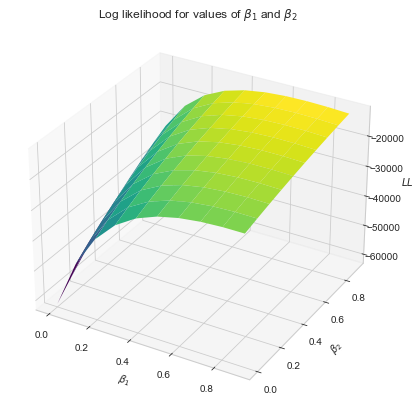

In [5]:
#We create our 3D space using NxN tuples. We set N = 10, as anything above requires too much computing power.
N = 10
shape_tuple = (N,N)
beta = mp.beta.copy()
beta0_values = np.empty(shape_tuple)
beta1_values = np.empty(shape_tuple)
beta2_values = np.empty(shape_tuple)
LL_values = np.empty(shape_tuple)

#The following loops create the i x j dimensional space using the three beta values, each being saved inside their own tuple.
#Afterwards, we run our log-Likelihood function for each iteration of beta and save those into a tuple. 
#Note: We don't need to run DGP again, since the part of data generation that is relying on beta (y_prb) exists
#in our log-likelihood function.

for i in range(N):
        for j in range(N):
            beta[0] = 0.15
            beta[1] = i/10
            beta[2] = j/10
            beta0_values[i,j] = beta[0]
            beta1_values[i,j] = beta[1]
            beta2_values[i,j] = beta[2]
            LL = log_likelihood(beta, y_obs, x_obs)
            LL_values[i,j] = LL
            
#With our three tuple, we can now put up our 3D graph
%matplotlib inline
fig = plt.figure(figsize=(10,7))# create the figure
ax = fig.add_subplot(1,1,1,projection='3d') # create a 3d axis in the figure 
ax.plot_surface(beta1_values,beta2_values,LL_values, cmap='viridis'); # create surface plot in the axis
ax.set_xlabel('$ \\beta_1 $')
ax.set_ylabel('$ \\beta_2 $')
ax.set_zlabel('$LL$')
ax.set_title('Log likelihood for values of $ \\beta_1$ and $ \\beta_2$'); 

We note that the values peak at the highest values of $\beta_1$ and $\beta_2$ as expected from the model.

**Question 3:** Estimate $\beta$ by maximum likelihood. You may use a gradient-free approach or gradients if you will. 

In [22]:
#Finding optimization of beta through scipy.optimize.
def max_likelihood(mp, y_obs, x_obs):
    def objective(beta, mp, y_obs=y_obs, x_obs=x_obs):
        return -log_likelihood(beta, y_obs, x_obs)
    
    res = minimize(objective, x0 = mp.beta, bounds = ((0,1),(0,1),(0,1)),  args = (mp, y_obs, x_obs))
    MLE = res.x
    return MLE

beta0_MLE, beta1_MLE, beta2_MLE = max_likelihood(mp, y_obs, x_obs)
print(f'Our MLE estimates comes to beta_0 = {beta0_MLE:.2f}, beta_1 = {beta1_MLE:.2f} and beta_2 = {beta2_MLE:.2f}')

beta_MLE = [beta0_MLE, beta1_MLE, beta2_MLE]
MLL = log_likelihood(beta_MLE, y_obs, x_obs)
print(f'Given our optimal beta values, we find the maximum log-likelihood to be = {MLL:.3f}')

Our MLE estimates comes to beta_0 = 1.00, beta_1 = 0.57 and beta_2 = 1.00
Given our optimal beta values, we find the maximum log-likelihood to be = -5306.998


**Question 4:** Based on your estimated parameters, simulate a choice `y_sim` pr individual in `x_obs`. Create an output table

In [8]:
#Simulate y_sim for each individual in x_obs, 
#calculate probability given parameters and observation and draw from distribution
y_sim = []
for obs in x_obs:
    y_prb = np.exp(obs @ beta_MLE) / (1 + np.exp(obs @ beta_MLE))
    y_sim.append(np.random.binomial(1, y_prb))
    
    
#We create a function that allows us to count how many times each scenario occurs.
def counter(obs,sim):
    count = 0
    for number in range(mp.N):
        if y_obs[number] == obs and y_sim[number] == sim:
            count += 1       
    return count


#We save our outcomes.
outcome_11 = counter(1,1)
outcome_10 = counter(1,0)
outcome_01 = counter(0,1)
outcome_00 = counter(0,0)


#We create a output table using the tabulate package (Requires pip install tabulate)
print(tabulate([['y_obs = 1 and y_sim = 1', outcome_11],
                ['y_obs = 1 and y_sim = 0', outcome_10],
                ['y_obs = 0 and y_sim = 1', outcome_01],
                ['y_obs = 0 and y_sim = 0', outcome_00]], 
                headers=['Outcome', 'Occurrances']))

Outcome                    Occurrances
-----------------------  -------------
y_obs = 1 and y_sim = 1          64634
y_obs = 1 and y_sim = 0           2649
y_obs = 0 and y_sim = 1          30801
y_obs = 0 and y_sim = 0           1916


Looking at the occurances, we note that the most likely scenario is where both the observed and the simulated choices are "taking the action". The next most common occurance is that the simulated choice is "taking the action", while the observed "doesn't take the action". Any occurance, where the simulation doesn't take an action, are very few ($4.7 \%$).

It is obvious that given our MLE parameters that the agent chooses to take the action in almost all the scenarios, choosing to take the action in $95.279$ of $100.000$ scenarios, while the agent in our observed data only takes an action in $67.283$ out of $100.000$ scenarios.

**Question 5:** Test if your initial guess of $\beta$ will have an impact on the final estimate. Why do you think there is/is not an impact? 

Since we have taken our SimpleNamescape values for $\beta$ as our initial guess of $\beta$, we can now simply run our function a few times while recalibrating our $\beta$ values.


In [9]:
mp.beta = np.array([1, 1, 1])
beta0_MLEv2, beta1_MLEv2, beta2_MLEv2 = max_likelihood(mp, y_obs, x_obs)
mp.beta = np.array([0, 0, 0])
beta0_MLEv3, beta1_MLEv3, beta2_MLEv3 = max_likelihood(mp, y_obs, x_obs)
mp.beta = np.array([0.1, 0.8, 0.1])
beta0_MLEv4, beta1_MLEv4, beta2_MLEv4 = max_likelihood(mp, y_obs, x_obs)

print(f'After running the model with different values of beta, we get the following results:')
print(f'beta_0 is = {beta0_MLEv2:.2f}, {beta0_MLEv3:.2f} and {beta0_MLEv4:.2f}')
print(f'beta_1 is = {beta1_MLEv2:.2f}, {beta1_MLEv3:.2f} and {beta1_MLEv4:.2f}')
print(f'beta_2 is = {beta2_MLEv2:.2f}, {beta2_MLEv3:.2f} and {beta2_MLEv4:.2f}')

After running the model with different values of beta, we get the following results:
beta_0 is = 1.00, 1.00 and 1.00
beta_1 is = 0.57, 0.57 and 0.57
beta_2 is = 1.00, 1.00 and 1.00


We must from that conclude that our initial guess of $\beta$ does not impact our final MLE estimate, meaning that we have found a global maximum, not just a local maximum.

# Consumption saving with borrowing

**Question 1** Solve the model for each type of household. Plot the value functions $v_1(m_1)$ and $v_2(m_2)$ in one graph for each household type. Comment on the differences.

Answers is a modification of functions from lecture 11:  
First define a **consumption function** a **bequest function** and a **value functions for period 1 and 2**:

In [10]:
def consumption(c,par):
    return c**(1-par.rho)/(1-par.rho)

def bequest(m,c,par):
    return par.nu*(m-c+par.kappa)**(1-par.rho)/(1-par.rho)

def v2(c2,m2,par):
    return consumption(c2,par) + bequest(m2,c2,par)


def v1(c1,m1,par,v2_interp):
    
    # a. v2 value, if low income
    m2_low = (1+par.r)*(m1-c1) + 1-par.Delta
    v2_low = v2_interp([m2_low])[0]
    
    # b. v2 value, if high income
    m2_high = (1+par.r)*(m1-c1) + 1+par.Delta
    v2_high = v2_interp([m2_high])[0]
    
    # c. expected v2 value
    prob_low = par.P_low
    prob_high = par.P_high
    expected_v2 = prob_low*v2_low + prob_high*v2_high
    
    # d. total value
    return consumption(c1,par) + par.beta*expected_v2

Then we define a **function solving for period 2**:

In [11]:
def solve_period_2(par):

    # a. grids
    m2_vec = np.linspace(1e-8,4,500)
    v2_vec = np.empty(500)
    c2_vec = np.empty(500)

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):

        # i. objective
        obj = lambda x: -v2(x[0],m2,par)

        # ii. initial guess(consuming half)
        x0 = m2/2

        # iii. optimizer
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-8,m2),))

        # iv. save
        v2_vec[i] = -result.fun
        c2_vec[i] = result.x
        
    return m2_vec,v2_vec,c2_vec

And at last we creat a **function solving for the first period:**

In [12]:
def solve_period_1(par,v2_interp):

    # a. grids
    m1_vec = np.linspace(1e-8,4,500)
    v1_vec = np.empty(500)
    c1_vec = np.empty(500)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda x: -v1(x[0],m1,par,v2_interp)
        
        # ii. initial guess (consuming half)
        x0 = m1/2
        
        # iii. bounds
        lower = 1e-12
        upper = m1 + (1-par.Delta)/(1+par.r)
        
        # iii. optimize
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((lower,upper),))
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x[0]
     
    return m1_vec,v1_vec,c1_vec

Now we create **parameters** for each type of household:

In [13]:
# Create parameters for each type of household
type1 = SimpleNamespace()

type1.rho = 3
type1.kappa = 0.5
type1.nu = 0.1
type1.r = 0.04
type1.beta = 0.95
type1.Delta = 0.5
type1.P_low = 0.9
type1.P_high = 0.1

type2 = SimpleNamespace()

type2.rho = 3
type2.kappa = 0.5
type2.nu = 0.1
type2.r = 0.04
type2.beta = 0.95
type2.Delta = 0.5
type2.P_low = 0.1
type2.P_high = 0.9

And then we begin to **solve for both periods and for both households**:

In [14]:
# Type 1 for period 1 and 2

# a. solve for period 2
m2_t1, v2_t1, c2_t1 = solve_period_2(type1)

# b. contruct interpolater
v2_interp = interpolate.RegularGridInterpolator([m2_t1], v2_t1,
                                                bounds_error=False,fill_value=None)
# c. solve for period 1
m1_t1, v1_t1, c1_t1 = solve_period_1(type1,v2_interp)


# Type 2 for period 1 and 2

# a. solve for period 2
m2_t2, v2_t2, c2_t2 = solve_period_2(type2)

# b. contruct interpolater
v2_interp = interpolate.RegularGridInterpolator([m2_t2], v2_t2,
                                                bounds_error=False,fill_value=None)

# c. solve for period 1
m1_t2, v1_t2, c1_t2 = solve_period_1(type2,v2_interp)

Now we **illustrate**  
First we plot the value functions $v_1(m_1)$ and $v_2(m_2)$ in one graph for each household type, and then we plot the optimal consumption functions $c_1^*(m_1)$ and $c_2^*(m_2)$ in one graph for each type of household.

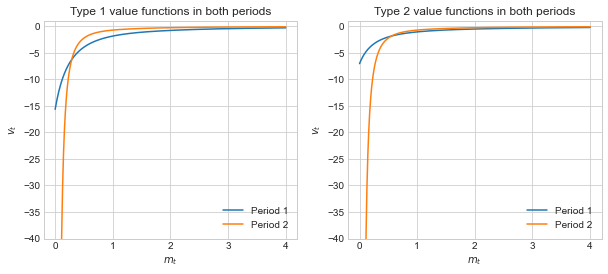

In [15]:
# Type 1 value function plot in both periods
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(m1_t1,v1_t1, label = 'Period 1')
ax1.plot(m2_t1,v2_t1, label = 'Period 2')
ax1.set_xlabel('$m_t$')
ax1.set_ylabel('$v_t$')
ax1.set_title('Type 1 value functions in both periods')
ax1.legend()
ax1.set_ylim([-40,1]);

# Type 2 plot value function plot in both periods
ax2 = fig.add_subplot(1,2,2)
ax2.plot(m1_t2,v1_t2, label = 'Period 1')
ax2.plot(m2_t2,v2_t2, label ='Period 2')
ax2.set_xlabel('$m_t$')
ax2.set_ylabel('$v_t$')
ax2.set_title('Type 2 value functions in both periods')
ax2.legend()
ax2.set_ylim([-40,1]);


As we see above the value functions are the same in period 2 for both households, while the value function for period 1 is higher for type 2 households. This is due to the higher probability that they will have a high income in period 2, and therefore spends more in period 1 due to income smoothing. Now we will plot for consumption

**Question 2** From the model solution, obtain the optimal consumption functions $c_1^*(m_1)$ and $c_2^*(m_2)$. Plot these in one graph for each type of household. Comment on the observed differences between household types. 

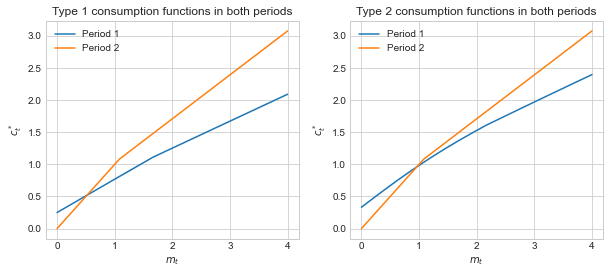

In [16]:
# Type 1 consumption function plot in both periods
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(m1_t1,c1_t1, label = 'Period 1')
ax1.plot(m2_t1,c2_t1, label = 'Period 2')
ax1.set_xlabel('$m_t$')
ax1.set_ylabel('$c^*_t$')
ax1.set_title('Type 1 consumption functions in both periods')
ax1.legend();

# Type 2 consumption function plot in both periods
ax2 = fig.add_subplot(1,2,2)
ax2.plot(m1_t2,c1_t2, label = 'Period 1')
ax2.plot(m2_t2,c2_t2, label ='Period 2')
ax2.set_xlabel('$m_t$')
ax2.set_ylabel('$c^*_t$')
ax2.set_title('Type 2 consumption functions in both periods')
ax2.legend();


We see that consumption in period 2 is the same for both households types. The kink is due to the negtive double derrivative of the utility deriving from consumption. So up until a certain point households will consume all their cash-on-hand, until it becomes viable to save. We also find that consumption in period 1 is lower for households of type 1. This is due to their lower expected income in period 2 why they need to save more of their income.

**Question 3** Simulate `simN` households of each type based on the distribution of $m_1$ below. You can use the same distribution for both household types. What is the fraction of households who *borrow* in period 1, $c_1 > m_1$, in each group?

In [23]:
def solve(par):
    
    # a. solve period 2
    m2_vec,v2_vec,c2_vec = solve_period_2(par)
    
    # b. construct interpolator
    v2_interp = interpolate.RegularGridInterpolator([m2_vec], v2_vec,
        bounds_error=False,fill_value=None)
    
    # b. solve period 1
    m1_vec,v1_vec,c1_vec = solve_period_1(par,v2_interp)
    
    return m1_vec,c1_vec,m2_vec,c2_vec

We are now ready to simulate the model:

**Step 1:** Solve and construct interpolators:

In [24]:
# Type 1
m1_t1,c1_t1,m2_t1,c2_t1 = solve(type1)

c1_interp_t1 = interpolate.RegularGridInterpolator([m1_t1], c1_t1,
                                                bounds_error=False,fill_value=None)

c2_interp_t1 = interpolate.RegularGridInterpolator([m2_t1], c2_t1,
                                                bounds_error=False,fill_value=None)

# Type 2
m1_t2,c1_t2,m2_t2,c2_t2 = solve(type2)

c1_interp_t2 = interpolate.RegularGridInterpolator([m1_t2], c1_t2,
                                                bounds_error=False,fill_value=None)

c2_interp_t2 = interpolate.RegularGridInterpolator([m2_t2], c2_t2,
                                                bounds_error=False,fill_value=None)

**Step 2:** Draw initail distribution of $m_1$ and simulate forward

In [26]:
np.random.seed(2021)
simN = 1000
# No one gets negative m in first period
sim_m1 = np.fmax(np.random.normal(1, 1, size = simN), 0)

# Period 1 type 1
sim_c1_t1 = c1_interp_t1(sim_m1)
sim_a1_t1 = sim_m1-sim_c1_t1

# Period 1 type 2
sim_c1_t2 = c1_interp_t2(sim_m1)
sim_a1_t2 = sim_m1-sim_c1_t2

# Get values under 0(households who borrow)
borrow_t1 = sim_a1_t1[sim_a1_t1<0]
borrow_t2 = sim_a1_t2[sim_a1_t2<0]

# Calculate fraction of households who borrow in period 1
borrow_frac_t1 = len(borrow_t1)/len(sim_c1_t1)
borrow_frac_t2 = len(borrow_t2)/len(sim_c1_t2)

print(f'The fraction of type 1 households who borrow in period one is {borrow_frac_t1:.3f} \
and for type 2 it is {borrow_frac_t2:.3f}')

The fraction of type 1 households who borrow in period one is 0.336 and for type 2 it is 0.489


We see that it is preferable for both household's type to begin to burrow since they have a strong preference to smooth consumption. Additionally, we find that households of type 2 have a higher willingness to borrow, since they expect a higher income in period 2.

# Division by Newton's method

**Question 1:** By applying the function $g(x)$ in Newton's method, we can avoid any use of division during the run of the algorithm.   
Derive the expression $\frac{g(x)}{g'(x)}$. Do you see why there is no division involved?



In [18]:
# a. define variables and functiosn in sympy and find derivative
x = sm.symbols('x')
d = sm.symbols('d')
func = 1/x - d
dfunc = sm.diff(func, x)
fx_div_fdx = func/dfunc

# b. print functions
display(func)
display(dfunc)
display(fx_div_fdx)

-d + 1/x

-1/x**2

-x**2*(-d + 1/x)

The variable called 'fx_div_fdx' denotes the expression $\frac{g(x)}{g'(x)}$ and is as seen above:

$$ \frac{g(x)}{g'(x)} = -x^2\left(\frac{1}{x}-d\right) = x^2 \cdot d - x$$

So instead of dividing $g(x)$ by $-\frac{1}{x^2}$, we multiply by $\left(-\frac{1}{x^2}\right)^{-1} = -x^2$ is multiplied. Hence, we can always rewrite the expression as $\frac{g(x)}{g'(x)} = g(x)\cdot g'(x)^{-1}$, why there is no division involved operation, and with the use of Newton's method, we can altogether avoid the use of division in the algorithm.

**Question 2:** Implement the algorithm below in code and test it. 


In [19]:
# Implement the algorithm

def newton_division(f, newt, par, max_iter=500, tol=1e-8):
    
    # step 1: initialise
    d_k = par.d_0
    k = 0
    
    # iteration
    while k < max_iter:
        
        # step 2: calculate
        gd_k = f(d_k, par.d)
        
        # step 3: check convergence
        if abs(gd_k) < tol:
            x = par.n*d_k
            k += 1
            break
        
        # step 4: new candidate root
        d_k = d_k - newt(d_k, par.d)
        
        
        # step 5: increment k
        k += 1

    return x, d_k, k

In [20]:
# a. lambdify
g = sm.lambdify((x, d), func)
gx_div_gdx = sm.lambdify((x,d), fx_div_fdx)

# b. set parameter values
par_newt = SimpleNamespace()

par_newt.n = 37.591
par_newt.d = 5.9
par_newt.d_0 = 0.2

# c. run function and print solution
x_root, d_tilde, k = newton_division(g, gx_div_gdx, par_newt)

print(f'In {k} iterations, we find that the root of g(x) is d_tilde = {d_tilde:.3f} \
which implies x = {x_root:.3f}')

# d. test function
print(f'given values of d and n the actual d_tilde = {1/par_newt.d:.3f} \
and the actual x = {par_newt.n/par_newt.d:.3f}')

In 5 iterations, we find that the root of g(x) is d_tilde = 0.169 which implies x = 6.371
given values of d and n the actual d_tilde = 0.169 and the actual x = 6.371


As we see above the algorithm find values similar to the actual values and we accept the algorithm as good.